#  Automatic Zoning Procedure (AZP) algorithm
Authors: [Xin Feng](https://github.com/xf37), [James Gaboardi](https://github.com/jGaboardi)

AZP can work with different types of objective functions, which are very sensitive to aggregating data from a large number of zones into a pre-designated smaller number of regions.

AZP was originally formulated in [Openshaw, 1977](https://www.jstor.org/stable/622300?casa_token=QITLwNVUPj4AAAAA%3AKXYVQHrdeAtefxZKkvxxUrWA_QCedSJrZwQD36F16Jfqx7Vq47uu1G_vp9I085Iozy_roZ_Dh6qQopZ6yXjfPsy4Y2aBqso-l0wZS2YqNv9pkh1JNXc&seq=1#metadata_info_tab_contents) and then extended in [Openshaw, S. and Rao, L. (1995)](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.461.8982&rep=rep1&type=pdf).

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-23T01:31:35.689534-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import libpysal
import spopt
from spopt.region import AZP

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.3.1

spopt    : 0.4.1+200.g336f235.dirty
geopandas: 0.11.1
json     : 2.0.9
libpysal : 4.6.2



## Mexican State Regional Income Clustering

To illustrate `azp` we utilize data on regional incomes for Mexican states over the period 1940-2000, originally used in [Rey and Sastré-Gutiérrez (2010)](https://www.tandfonline.com/doi/full/10.1080/17421772.2010.493955?casa_token=r6iIZaEKaywAAAAA%3ARxjQkEOcxQ5gffa1EGyd2rByA6w0uVxg5cU3v4VaSmx2u89Nr3oSe2f_n63CV20Ysrjs07U47m98). 

We can first explore the data by plotting the per capital gross regional domestic product (in constant USD 2000 dollars) for each year in the sample, using a quintile classification:

In [3]:
pth = libpysal.examples.get_path("mexicojoin.shp")
mexico = geopandas.read_file(pth)

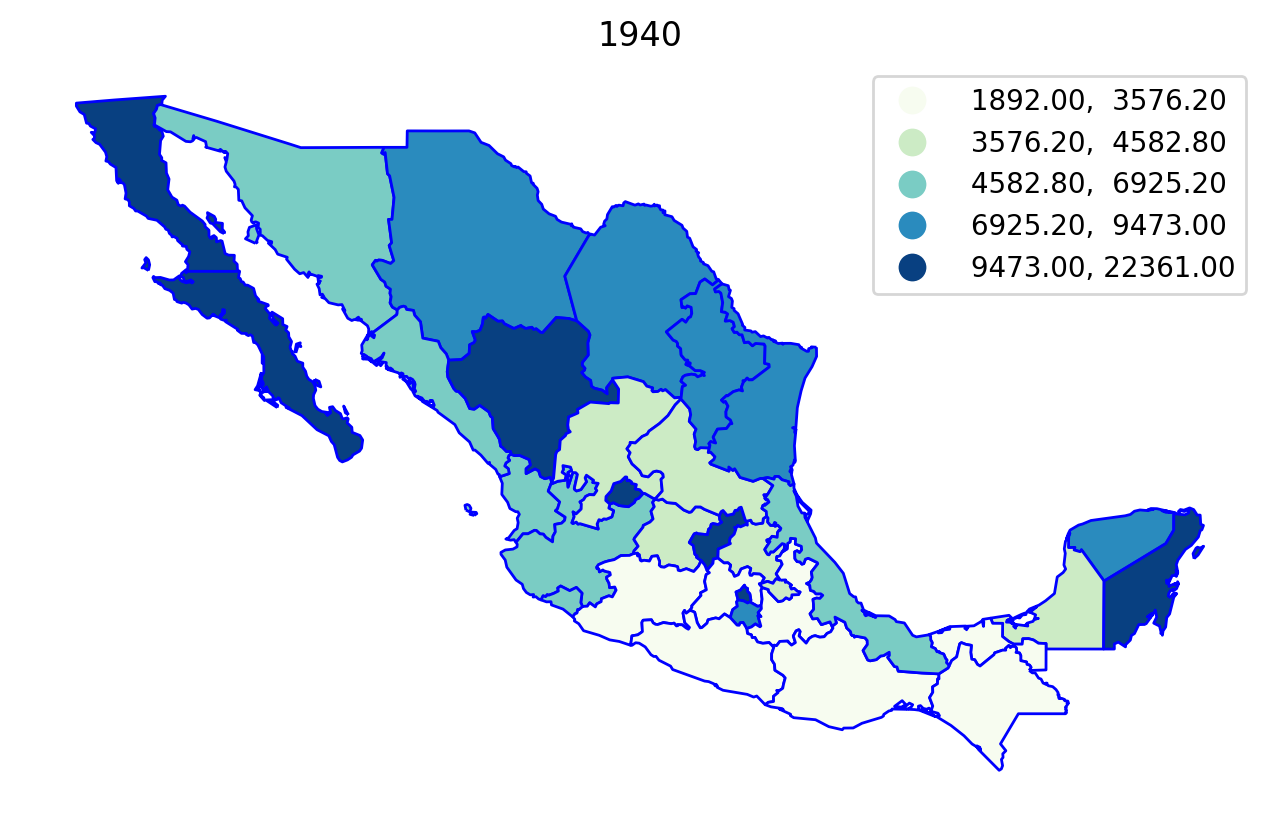

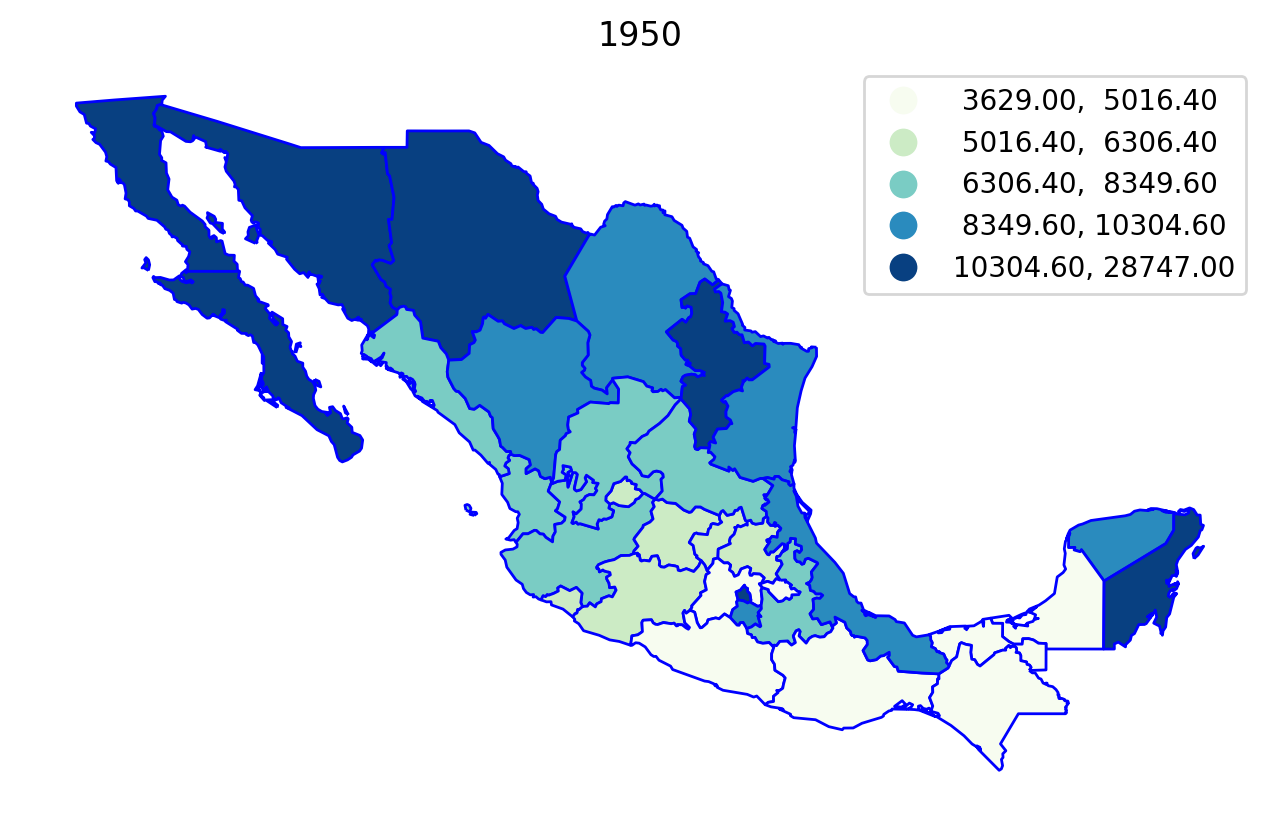

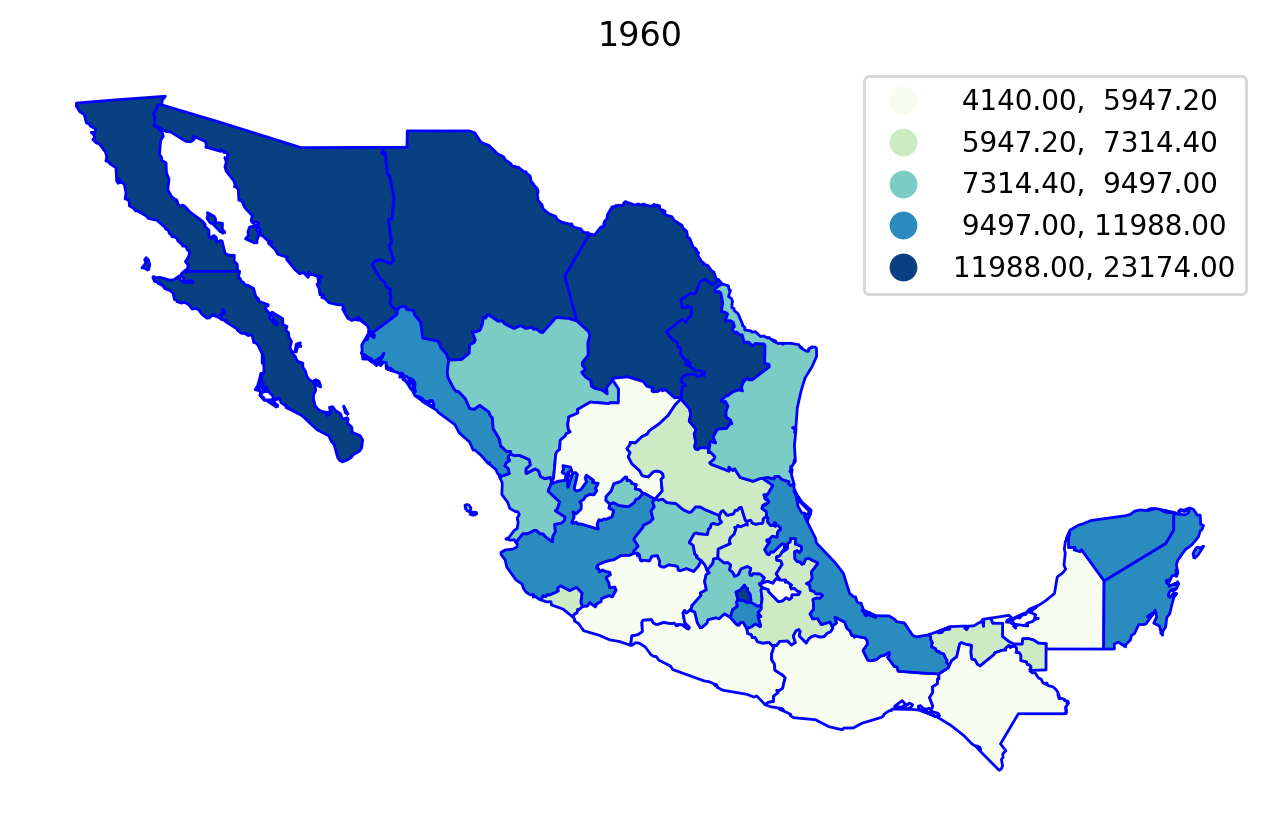

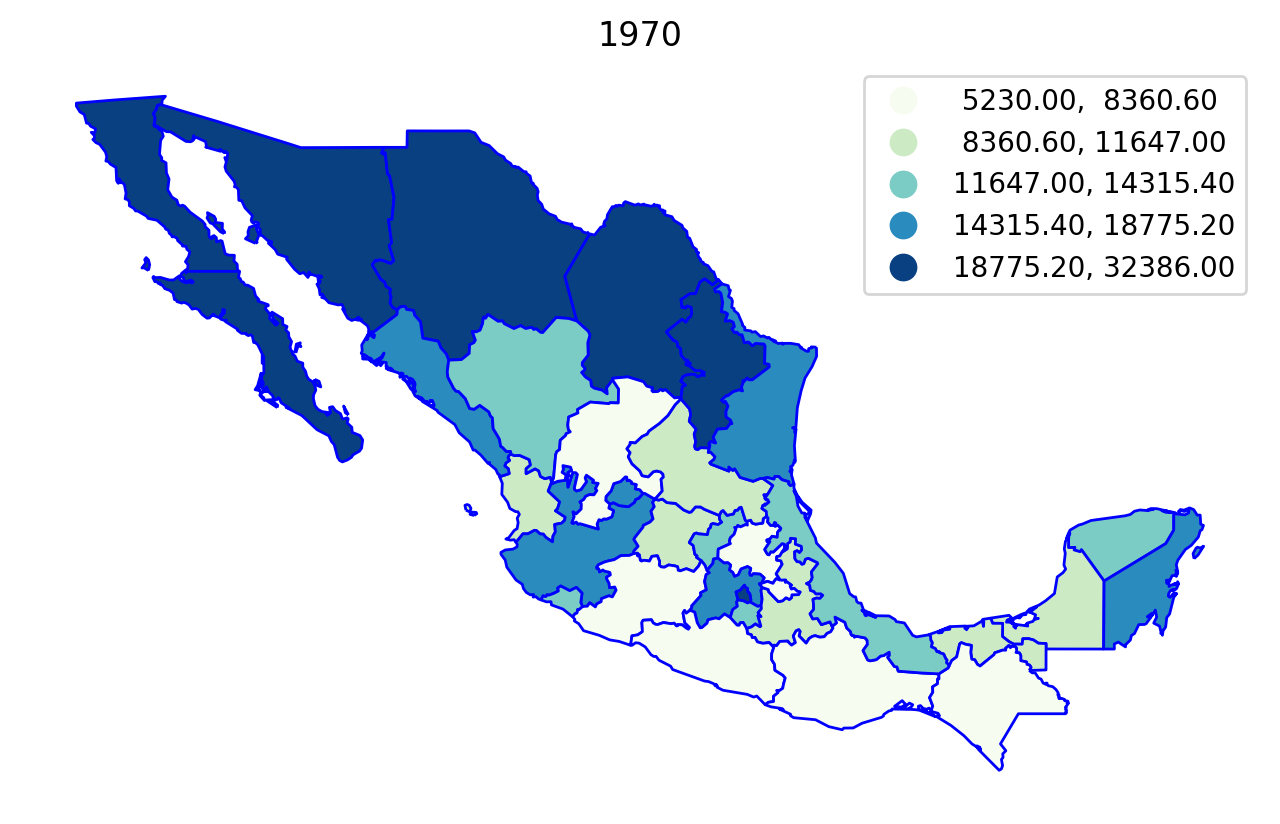

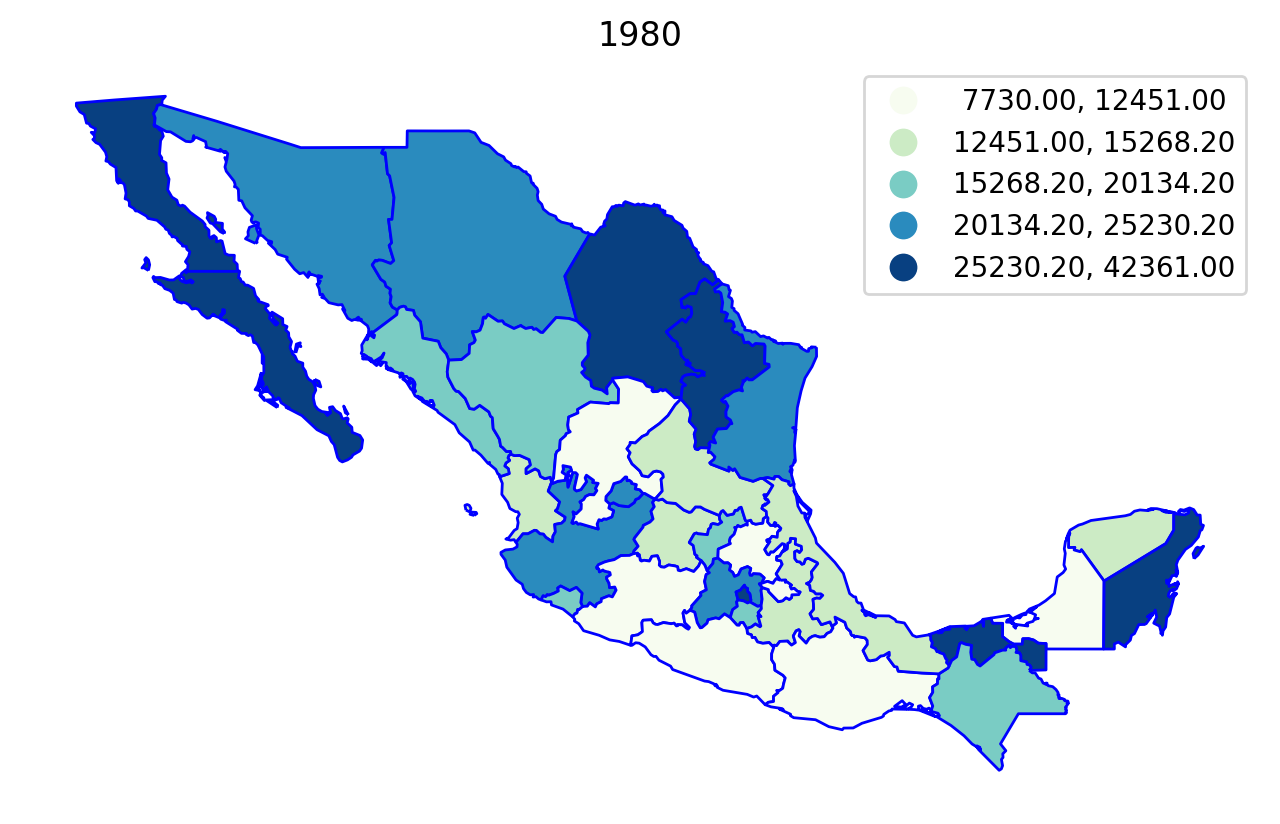

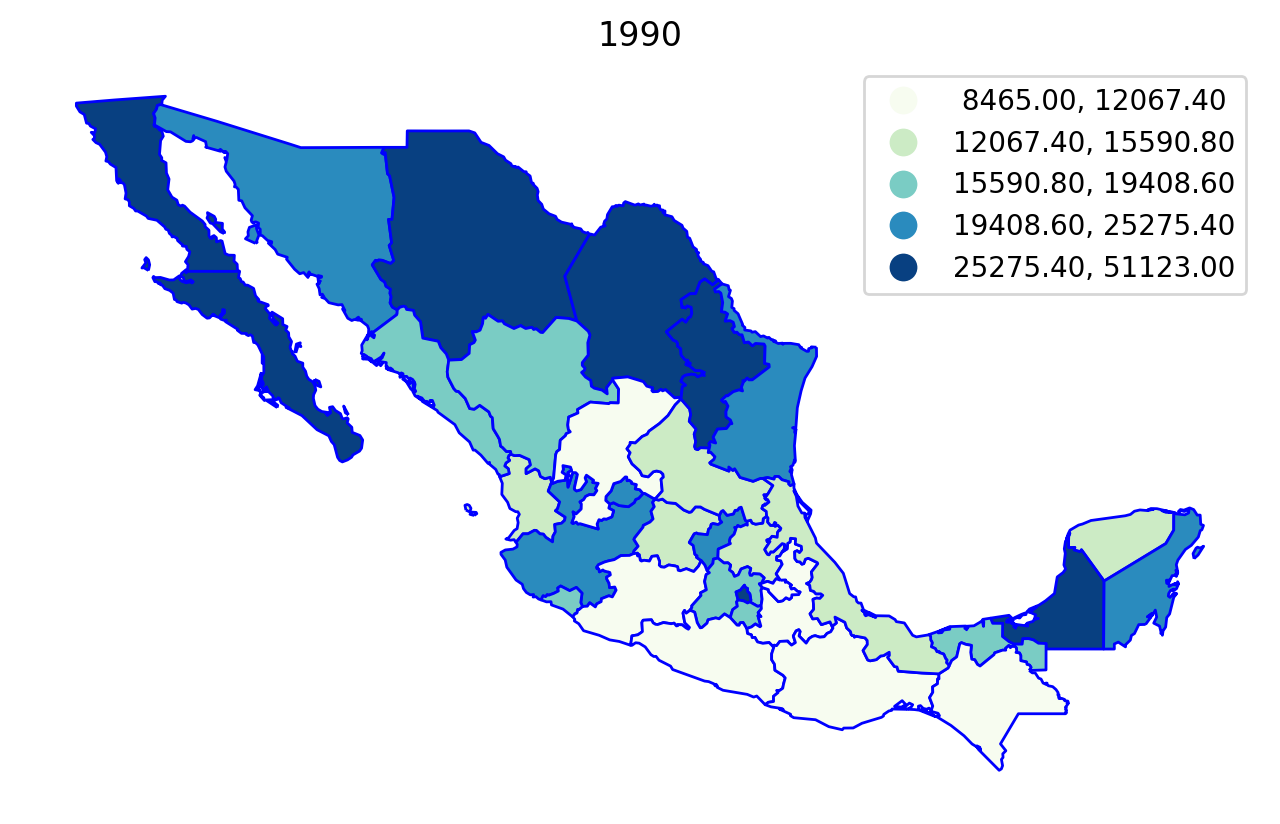

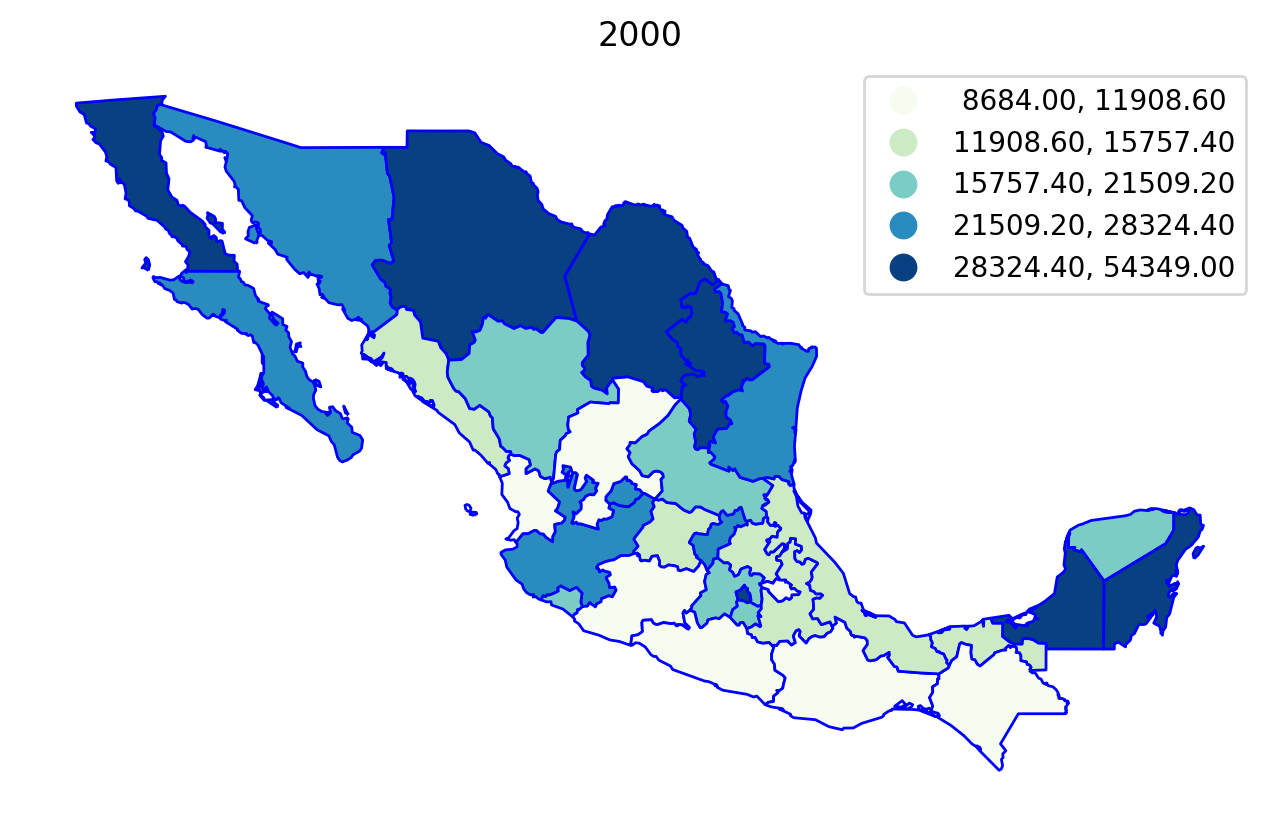

In [4]:
for year in range(1940, 2010, 10):
    base = mexico.plot(
        figsize=(8, 5),
        column=f"PCGDP{year}",
        scheme="Quantiles",
        cmap="GnBu",
        edgecolor="b",
        legend=True,
    )
    base.axis("off")
    base.set_title(str(year))

## Regionalization

First, we specify a number of parameters that will serve as input to the `azp` model.

The variables in the dataframe that will be used to measure regional dissimilarity:

In [5]:
attrs_name = [f"PCGDP{year}" for year in range(1950, 2010, 10)]
attrs_name

['PCGDP1950', 'PCGDP1960', 'PCGDP1970', 'PCGDP1980', 'PCGDP1990', 'PCGDP2000']

A [spatial weights object](https://pysal.org/libpysal/tutorial.html) expresses the spatial connectivity of the zones:

In [6]:
w = libpysal.weights.Queen.from_dataframe(mexico)

The number of regions that we would like to aggregate these zones into:

In [7]:
n_clusters = 5

There are four optional parameters. In this example, we only use the default settings, you can define them as needed.

allow_move_strategy: For a different behavior for allowing moves, an AllowMoveStrategy instance can be passed as argument.

    class: AllowMoveStrategy or None, default: None
                       
random_state: Random seed.

    None, int, str, bytes, or bytearray, default: None
            
initial_labels: One-dimensional array of labels at the beginning of the algorithm.
    
    class: numpy.ndarray or None, default: None
    If None, then a random initial clustering will be generated.  

objective_func: the objective function to use.

    class: spopt.region.objective_function.ObjectiveFunction, default: ObjectiveFunctionPairwise()

The model can then be solved:

In [8]:
model = AZP(mexico, w, attrs_name, n_clusters)
model.solve()

n_regions_per_comp {0: 5}
comp_label 0
n_regions_in_comp 5
Regions in comp: {0, 1, 2, 3, 4}


In [9]:
mexico["azp_new"] = model.labels_

In [10]:
mexico["number"] = 1
mexico[["azp_new", "number"]].groupby(by="azp_new").count()

,number
azp_new,
0.0,7
1.0,7
2.0,9
3.0,2
4.0,7


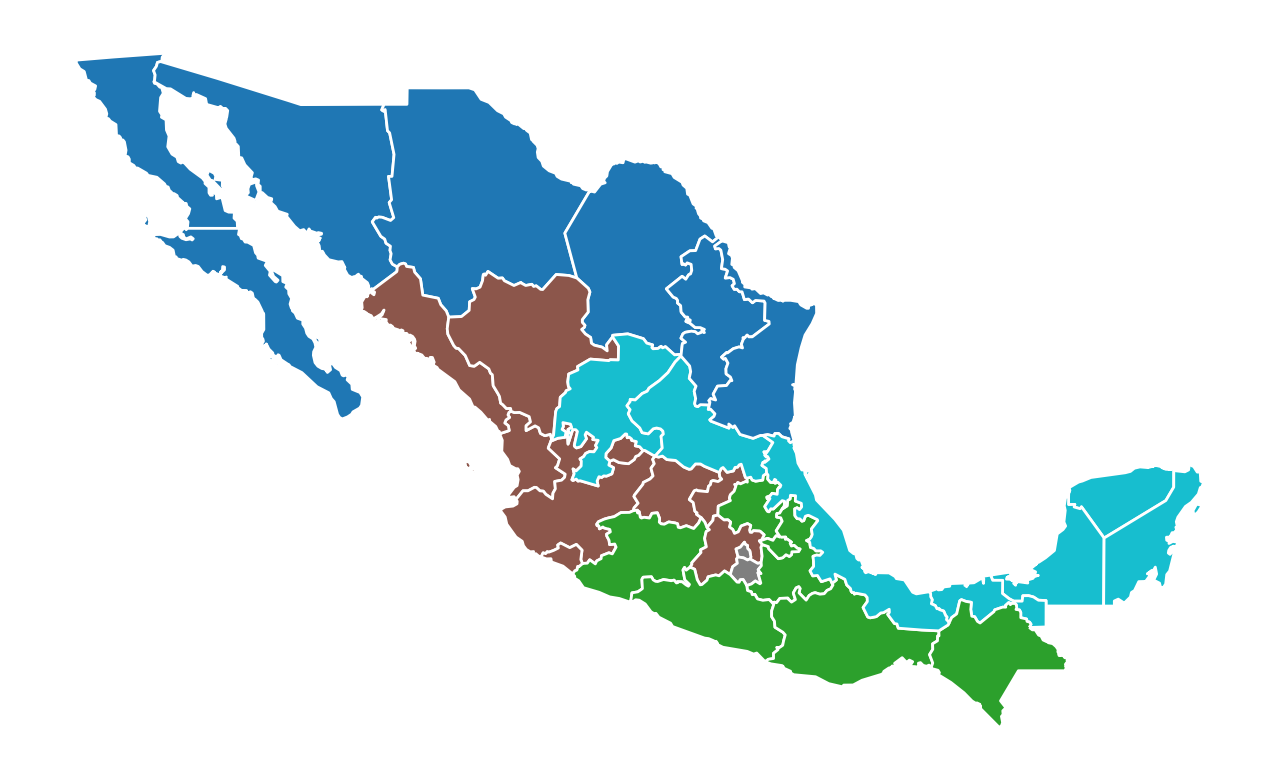

In [11]:
mexico.plot(figsize=(8, 5), column="azp_new", categorical=True, ec="w").axis("off");

The model solution results in five regions, two of which have five states, one with four, one with eight, and one with ten states. 

## Year-by-Year Regionalization (n_clusters = 5 regions)

n_regions_per_comp {0: 5}
comp_label 0
n_regions_in_comp 5
Regions in comp: {0, 1, 2, 3, 4}
n_regions_per_comp {0: 5}
comp_label 0
n_regions_in_comp 5
Regions in comp: {0, 1, 2, 3, 4}
n_regions_per_comp {0: 5}
comp_label 0
n_regions_in_comp 5
Regions in comp: {0, 1, 2, 3, 4}
n_regions_per_comp {0: 5}
comp_label 0
n_regions_in_comp 5
Regions in comp: {0, 1, 2, 3, 4}
n_regions_per_comp {0: 5}
comp_label 0
n_regions_in_comp 5
Regions in comp: {0, 1, 2, 3, 4}
n_regions_per_comp {0: 5}
comp_label 0
n_regions_in_comp 5
Regions in comp: {0, 1, 2, 3, 4}


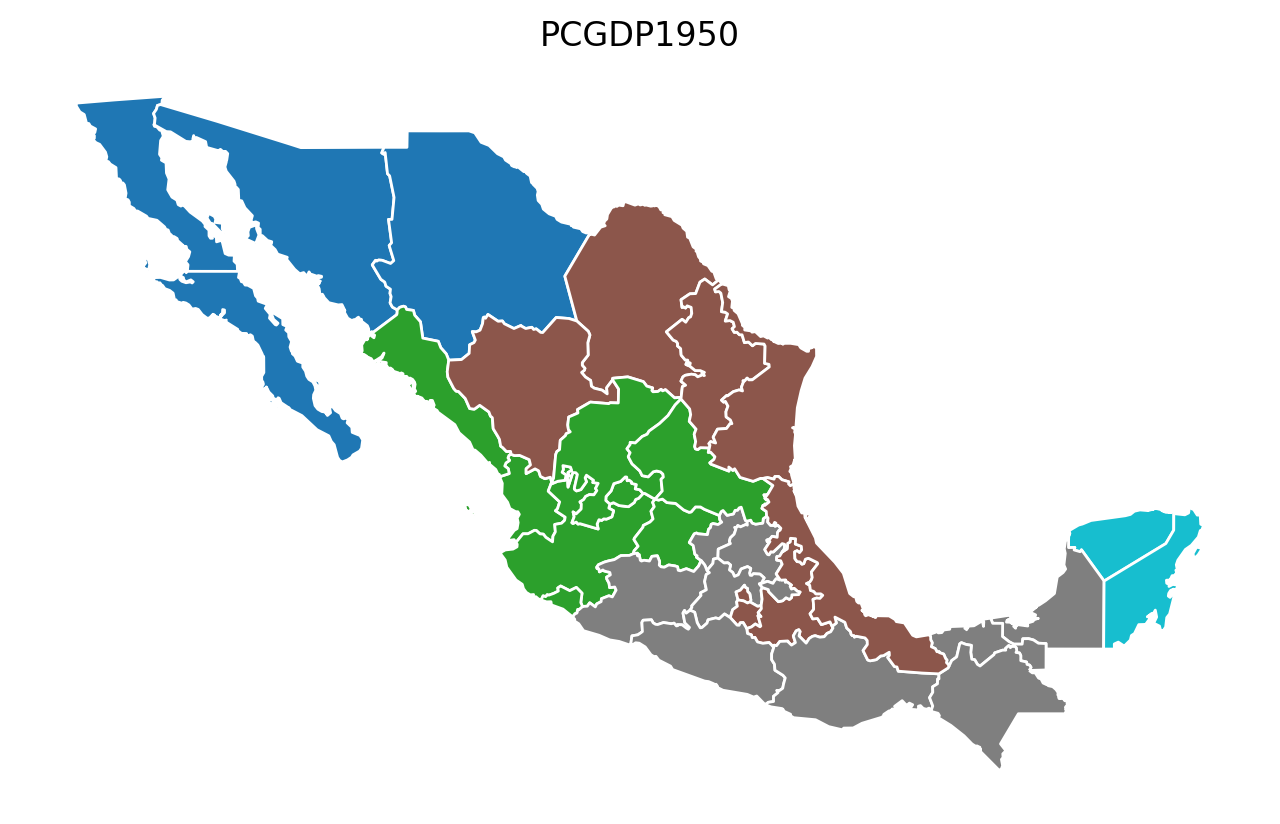

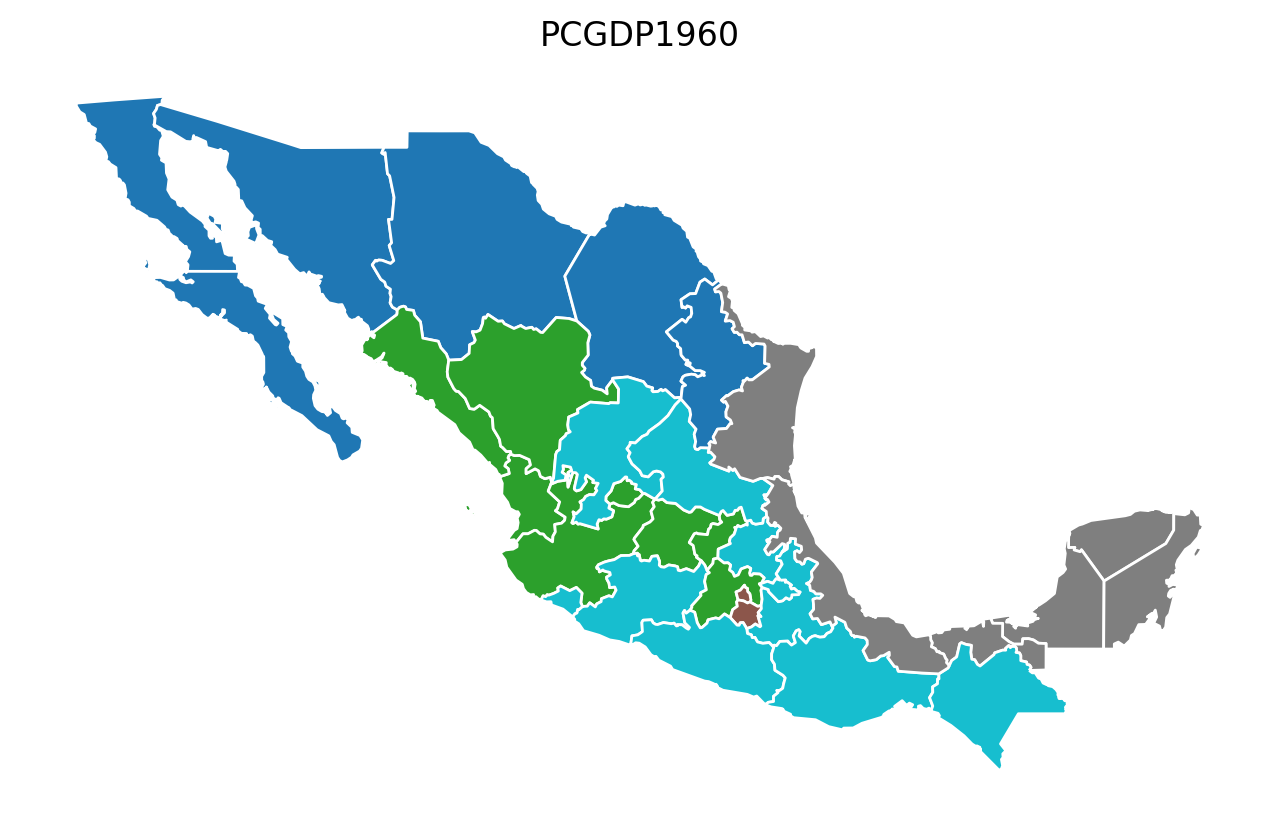

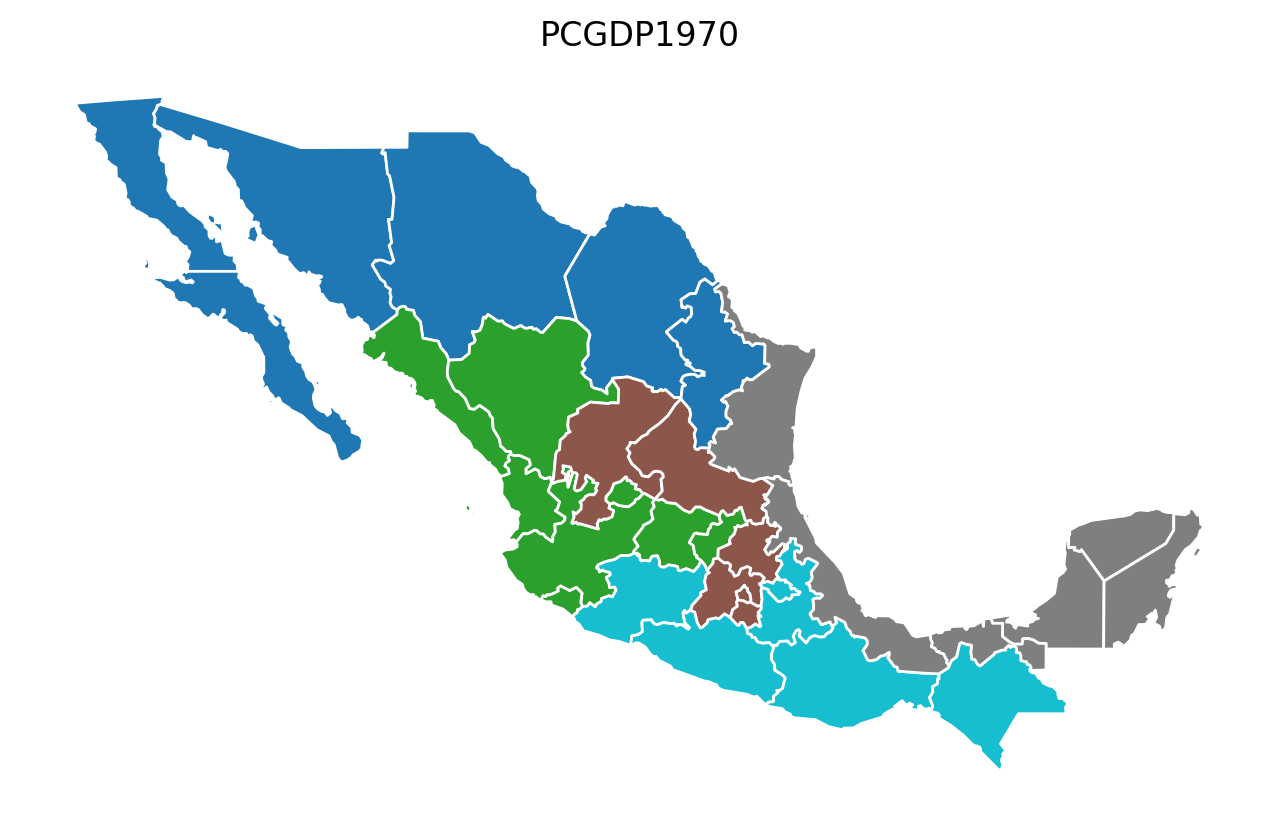

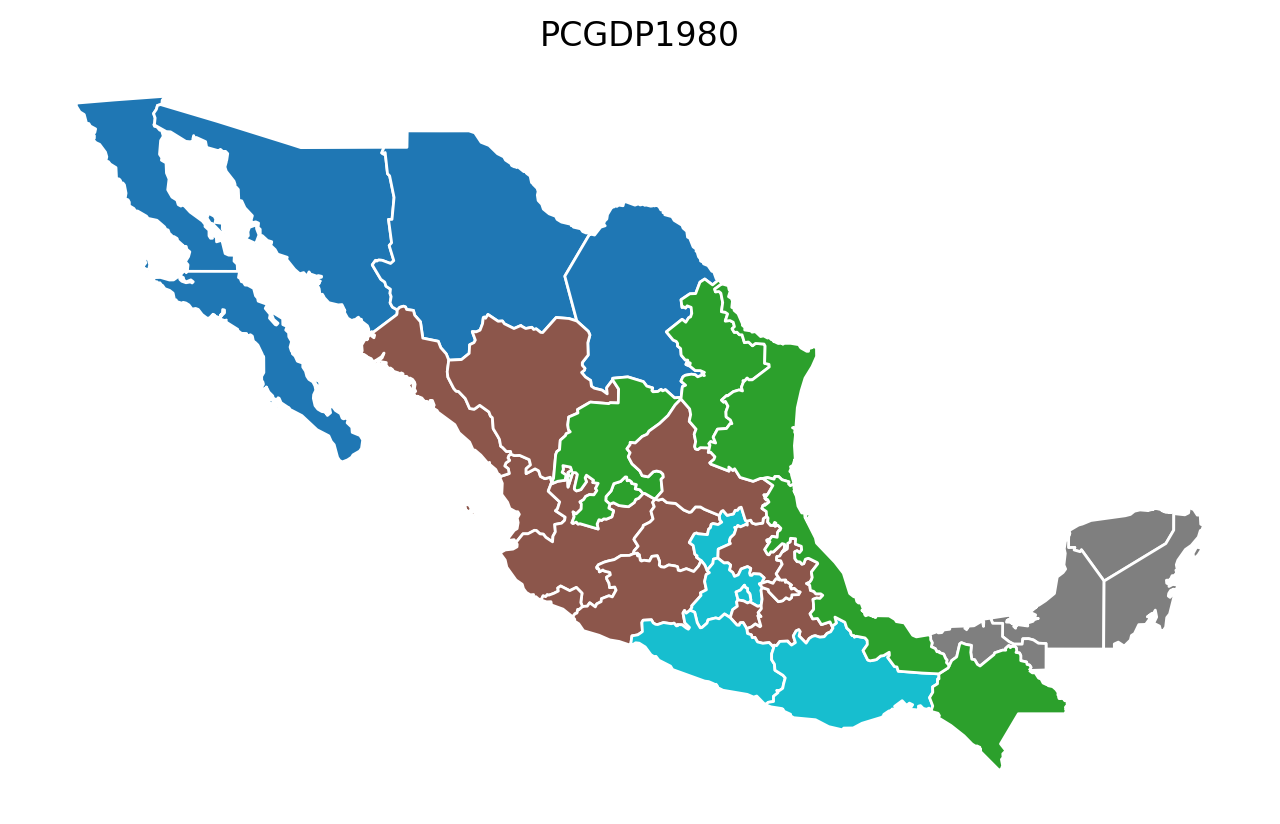

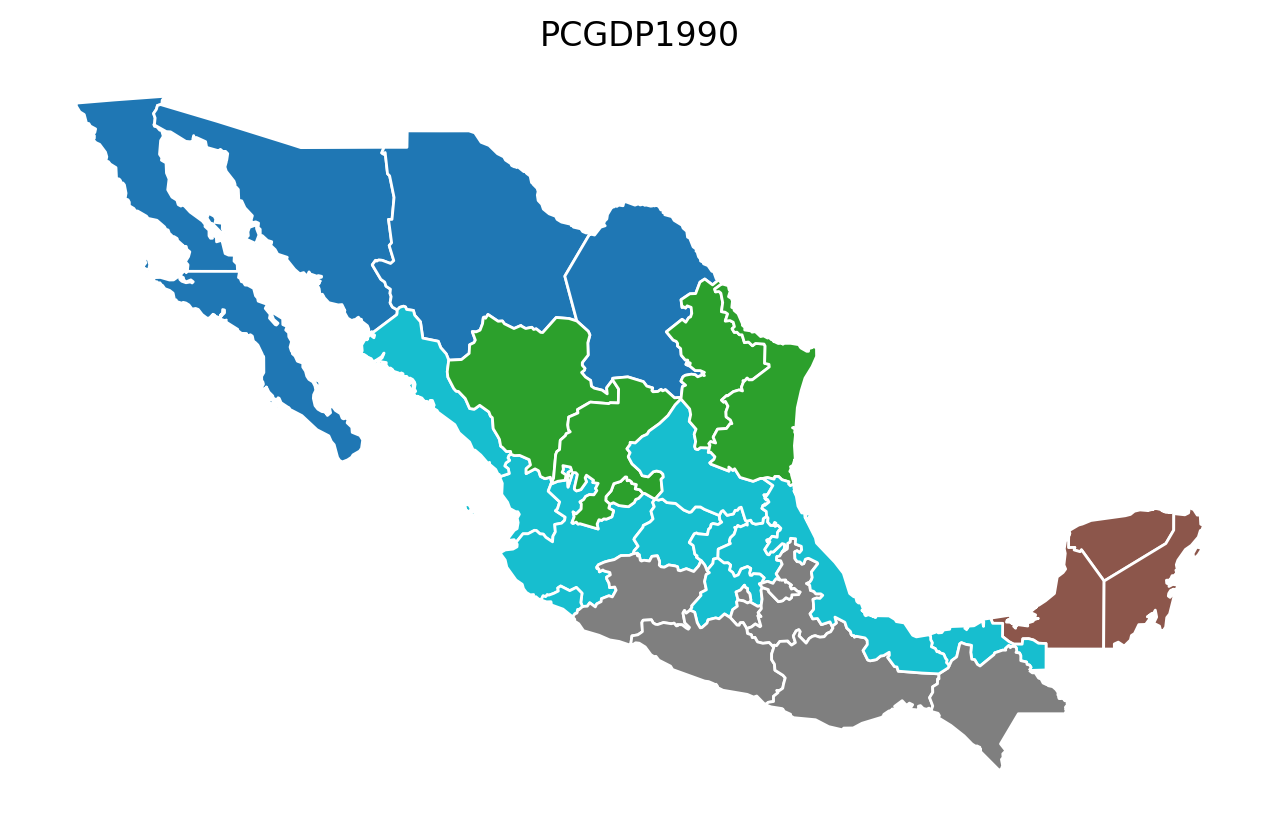

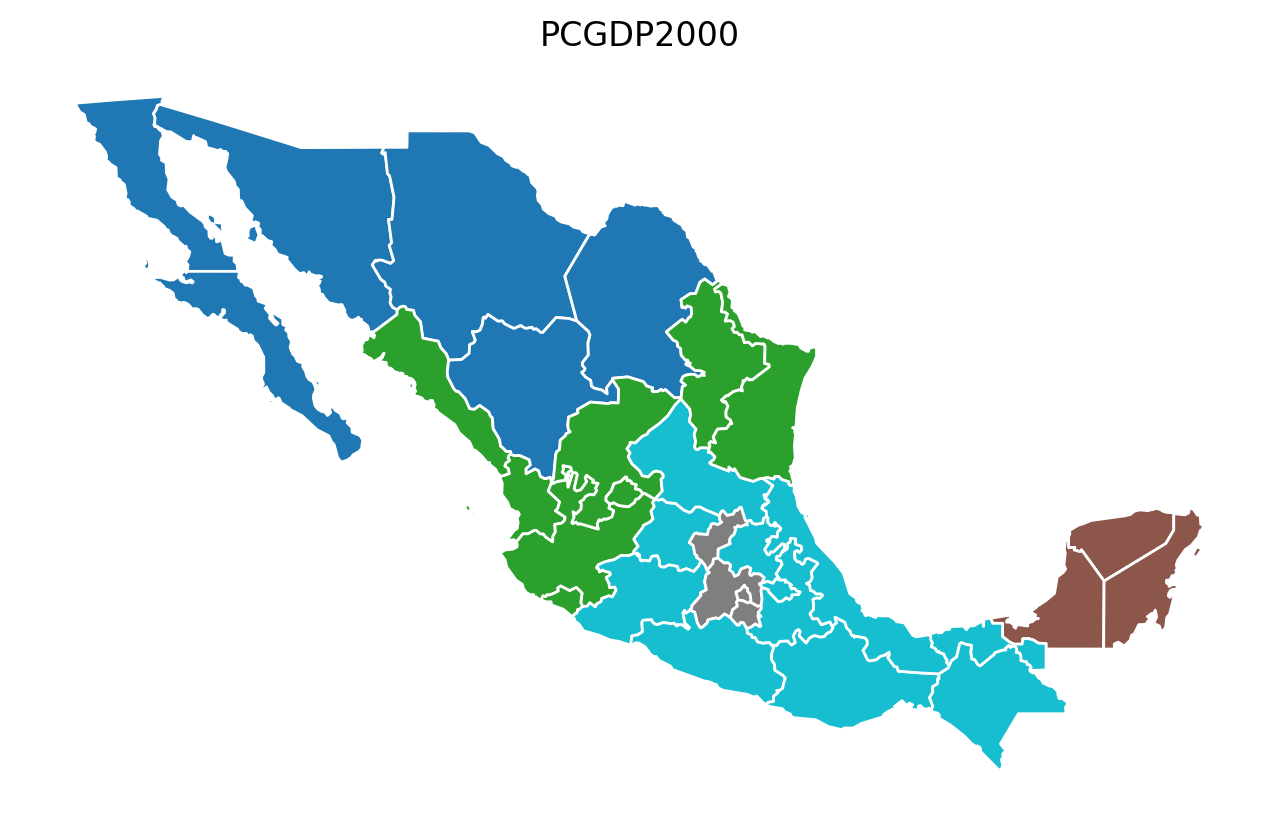

In [12]:
for year in attrs_name:

    model = AZP(mexico, w, year, 5)
    model.solve()
    lab = year + "labels_"
    mexico[lab] = model.labels_
    base = mexico.plot(figsize=(8, 5), column=lab, categorical=True, edgecolor="w")
    base.axis("off")
    base.set_title(year)